# Exercise 05-1: Part b) Logistic Adaline model

**NOTE:** The behavior you see will depend crucially on the random seed that is used to generate the random numbers for the shuffling of the data. Depending on the choice of training data, you might have to adapt the learning rates in order to see the expected behavior for "too small" and "too large" values. There are two possibilities to get reproduceable results:
* Fix the random seed for Numpy [random.seed()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html?highlight=seed#numpy.random.seed)
* Use the entire data as training data (the distinction between test and training data will become relevant when we look at cross-validateion techniques)

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# For the animation feature we need another module of Matplotlib
import matplotlib.animation as animation
# as well as an IPython library to display the animation as HTML element
from IPython.display import HTML

%matplotlib inline
%config InlineBackend.figure_format='svg'

## Data preparation

We load the Iris data set from:

https://archive.ics.uci.edu/ml/datasets/iris

Since this data set has become the machine learning "Hello, World!"
equivalent, it is also part of many machine learning libraries. Have a look
at the Python module  `sklearn` submodule `datasets`, for example, which was
used
[here](https://gitlab.com/dirk-deckert-lmu/maml-ss20/-/blob/master/material/lec01/iris_plot.py)
to geenrate the Iris plot for the lecture notes.

Note that the column names are missing in the CSV file. They are described in
the accompanying file
https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names.

In [2]:
file_name = 'iris_data_set.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal length [cm]', 'sepal width [cm]',
                'petal length [cm]', 'petal width [cm]', 'iris type']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from `https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data`...
Done.


**NOTE:** that for the logistic Adaline we employ the labels $\mathcal Y=\{0,1\}$ instead of $\mathcal Y=\{-1,+1\}$:

In [3]:
CLASS_LABEL_1 = 0
CLASS_LABEL_2 = 1

df['class'] = df['iris type'].replace(
    ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
    [CLASS_LABEL_1, CLASS_LABEL_2, CLASS_LABEL_2])

and furthermore, shuffle the data:

In [4]:
def shuffle_df(df, training_data_fraction, random_state=None):
    '''
    Split all available data into a training and test data set.
    
    Parameters
    -----------
    df : DataFrame
        DataFrame of available data.
    training_data_fraction : float
        The fraction of the data that should be used for training.
        E.g., `training_data_fraction=0.6` means 60%.
    random_state : int or numpy.random.RandomState, optional
        Allows to fix the seed for the pseudo-random numbers, 
        which is helpful for debugging in order to reproduce results.
        
    Returns
    -------
    Tuple of lists for test and training data.    
    '''
    # first, we use the `sample()` function to select a fraction of the data
    # frame for the training data
    train_df = df.sample(frac=training_data_fraction, 
                         random_state=random_state)
    # second, we use the index of the just defined training data in the
    # function `drop()` that drops the respective entries from the data frame,
    # thus, leaving only the rest of the entries for our test data
    test_df = df.drop(train_df.index)
    return train_df, test_df

In [5]:
training_data_fraction = .8

train_df, test_df = shuffle_df(df, training_data_fraction)

# convert DataFrame entries to Numpy arrays
# `train_X, train_Y`: training data
# `test_X, test_Y`: training data

train_X = train_df[['sepal length [cm]', 'sepal width [cm]']].to_numpy().reshape(len(train_df), 2, 1)
train_Y = train_df['class'].to_numpy()

test_X = test_df[['sepal length [cm]', 'sepal width [cm]']].to_numpy().reshape(len(test_df), 2, 1)
test_Y = test_df['class'].to_numpy()

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 120
      Test data samples: 30


## Definition of the logistic Adaline

The logistic Adaline model comprises:
* the activation function $\alpha(z)=\frac{1}{1-e^{-z}}$
* the classifier $h_{w,b}(x)=\text{sign}\left(\alpha(w\cdot x+b)-\frac12\right)$

and to avoid the vanishing gradient problem, we apply the 
* cross-entropy loss $L(y,y')=-\left[y\log y'+(1-y)\log(1-y')\right]$

In [6]:
class LogisticMiniBatchAdaline:
    
    def __init__(self, w, b, eta):
        '''
        Initializes the model parameters.

        Parameters
        ----------
        w : Array
            Array of correct dimension that specifies the weight row vector.
        b : float
            Bias term.
        eta: float
            Learning rate.
        '''
        self._w = w
        self._b = b
        self._eta = eta
        
    def alpha(self, Z):
        '''
        Activation function
        
        Parameters
        ----------
        Z : Array
            Array of activation input.
            
        Returns
        -------
        Array of logictic activation output.
        '''
        return 1.0 / ( 1.0 + np.exp(-Z) )
        
    def h(self, X):
        '''
        Evaluates the hypothesis corresponding to the given model parameters.

        Parameters
        ----------
        X : Array
            Array of correct dimension (transpose of the weight row vector).
            
        Returns
        -------
        Array of evaluations.

        '''
        activation_input = self._w @ X + self._b
        activation_output = self.alpha(activation_input)
        # Numpy's `where` function provides a fast substitution even for larger
        # arrays
        return np.where(activation_output < (CLASS_LABEL_2 + CLASS_LABEL_1)/2.0, CLASS_LABEL_1, CLASS_LABEL_2)
    
    def train(self, batch_X, batch_Y, epochs=1, mini_batches=1, verbose=False):
        '''
        Executes the update rule for a certain number of epochs and adapts the internal
        model parameters to the Adaline update rule.

        Parameters
        ----------
        bacth_X : Array
            Array of feature vectors.
        batch_Y : Array
            Array of class labels.
        epochs : int (optional)
            Number of epochs to train.
        verbose : bool
            True to print progress messages.

        Returns
        -------
        Tuple of lists of number of errors and loss
        '''
        loss_list = []
        err_list = []
        for e in range(epochs):
            
            # in order to shuffle the data we create a permutation of indices
            perm = np.random.permutation(len(batch_X))
            # and split this list of indices into mini batches of `batch_size`
            perm_list = np.array_split(perm, mini_batches)
            
            # carry out the update over the mini batches
            loss = 0
            errors = 0
            for p in perm_list:
                
                # select the features and labels of the permutation `p`
                X = batch_X[p]
                Y = batch_Y[p]
                        
                activation_input = self._w @ X + self._b
                activation_output = self.alpha(activation_input)
            
                delta_b_list = Y.reshape(len(Y), 1, 1) - activation_output
                delta_w_list = delta_b_list * X
    
                self._b += self._eta * delta_b_list.mean(axis=0)
                self._w += self._eta * delta_w_list.mean(axis=0).T
            
                # compute the cross entropy loss in this mini batch
                loss += -np.mean(Y * np.log(activation_output.ravel()) + (1-Y) * np.log(1 - activation_output.ravel()))   

            # count the number of errors
            errors = (batch_Y != self.h(batch_X).ravel()).sum()
            
            # record the loss averages over all mini batches
            loss_list.append(loss/mini_batches)
            # record the loss and number of errors
            err_list.append(errors)
            
            # the last few lines print an update every 10%
            progress = e * 100.0 / epochs
            if verbose and progress % 10 == 0:
                print(f'{progress:.2f}% of epochs finished. Current number of classification errors: {errors}')
        if verbose:
            print('100%.')
        return loss_list, err_list

## Plotting function

**NOTE:** Since the class labels have changed we had to adapt our plotting function, too.

In [7]:
def plot_iris_decision_regions(model):
    '''
    Plot decision regions and test and training data for class labels `CLASS_LABEL_1`, `CLASS_LABEL_2`.
    
    Parameters
    ----------
    model : classifier model class
    '''

    # compute how large the mesh for the contour plot shall be (with +/- 1 as
    # safety bleed)
    x1_min = train_X[:, 0].min() - 1
    x1_max = train_X[:, 0].max() + 1
    x2_min = train_X[:, 1].min() - 1
    x2_max = train_X[:, 1].max() + 1

    # compute grid for contour plot
    x1_list, x2_list = np.meshgrid(np.arange(x1_min, x1_max, .01), 
                                np.arange(x2_min, x2_max, .01))
    # meshgrid produces two arrays of the size `len(np.arange(x1_min, x1_max,
    # .01))` times `len(np.arange(x2_min, x2_max, .01))` so that computations can
    # be easily be vectorized.  As our hypothesis expects a list of (2,1) vector we
    # reshape this array
    X_list = np.dstack([x1_list, x2_list]).reshape(*x1_list.shape, 2, 1)
    # present it our hypothesis for evaluation and reshape it to have the desired
    # form as expected by the contour plot.
    h_list = model.h(X_list).reshape(x1_list.shape)
    
    # contourf() interpolates the colors over the found values.
    # So let us check if there are only one or two values in h_list.
    h_extrema = h_list.min(), h_list.max()
    if h_extrema[1] == CLASS_LABEL_1:
        # entire h_list hast class has class label 1
        colors = ['red']
    elif h_extrema[0] == CLASS_LABEL_2:
        # entire h_list hast class label 2
        colors = ['blue']
    else:
        # both class labels found in h_list
        colors = ['red', 'blue']
    cmap = matplotlib.colors.ListedColormap(colors)
    plt.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

    train_X_minus1 = train_X[train_Y == CLASS_LABEL_1]
    train_X_plus1 = train_X[train_Y == CLASS_LABEL_2]

    plt.scatter(train_X_minus1[:, 0], train_X_minus1[:, 1], marker='x', color='red', label='Train: Iris-setosa', alpha=.7)
    plt.scatter(train_X_plus1[:, 0], train_X_plus1[:, 1], marker='x', color='blue', label='Train: other', alpha=.7)

    test_X_minus1 = test_X[test_Y == CLASS_LABEL_1]
    test_X_plus1 = test_X[test_Y == CLASS_LABEL_2]
    plt.scatter(test_X_minus1[:, 0], test_X_minus1[:, 1], marker='.', color='red', label='Test: Iris-setosa', alpha=.7)
    plt.scatter(test_X_plus1[:, 0], test_X_plus1[:, 1], marker='.', color='blue', label='Test: other', alpha=.7)

    plt.xlabel('sepal width [cm]')
    plt.xlim(x1_min, x1_max)
    plt.ylabel('sepal length [cm]')
    plt.ylim(x2_min, x2_max)
    plt.legend()

## Render an animation using the current model using bad initial parameters

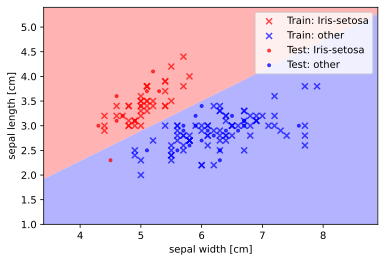

In [8]:
# For the animation feature we need another module of Matplotlib
import matplotlib.animation as animation
# as well as an IPython library to display the animation as HTML element
from IPython.display import HTML

number_of_plots = 100
plot_after_epochs = 10

# initial model parameters
w = np.array([[-1.0, 1.0]])
b = 0.0
# learning rate $\eta$
eta = .1

model = LogisticMiniBatchAdaline(w, b, eta)

fig, ax = plt.subplots()

loss_list = []
err_list = []
# plotting function per frame of the animation
def animate(i):
    global loss_list
    global err_list
    plt.cla()
    loss, errors = model.train(train_X, train_Y, plot_after_epochs, verbose=False)
    loss_list += loss
    err_list += errors
    plot_iris_decision_regions(model)

# render the animation
anim = animation.FuncAnimation(fig, animate, number_of_plots)

# show the the animation in HTML
HTML(anim.to_html5_video())

### And plot the loss and errors per epoch

In [9]:
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(err_list)
plt.xlabel('epoch')
plt.ylabel('errors')
plt.show()

## Non-linearly-separable case

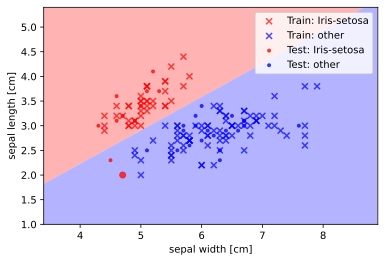

In [10]:
import matplotlib.animation as animation
from IPython.display import HTML

number_of_plots = 100
plot_after_epochs = 10

# initial model parameters
w = np.array([[0.0, 1.0]])
b = -1.0
# learning rate $\eta$
eta = .04

model = LogisticMiniBatchAdaline(w, b, eta)

# let us add a new data point of class -1 such that the training data becomes non-lin. separable
non_sep_X = np.array([[[4.7],[2]]])
non_sep_Y = np.array([-1])
# add the point to our training data
non_sep_train_X = np.concatenate((train_X, non_sep_X))
non_sep_train_Y = np.concatenate((train_Y, non_sep_Y))

fig, ax = plt.subplots()

loss_list = []
err_list = []
def animate(i):
    global loss_list
    global err_list
    plt.cla()
    loss, errors = model.train(train_X, train_Y, plot_after_epochs, verbose=False)
    loss_list += loss
    err_list += errors
    plot_iris_decision_regions(model)
    # plot the additional point
    plt.scatter(non_sep_X[:,0], non_sep_X[:,1], marker='o', color='red', label='Train: Iris-setosa', alpha=.7)


anim = animation.FuncAnimation(fig, animate, number_of_plots)

HTML(anim.to_html5_video())

### And plot the loss and errors per epoch

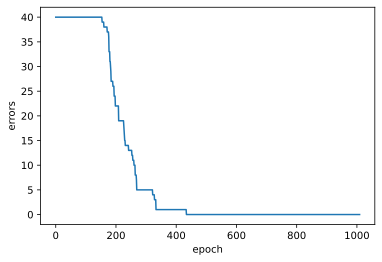

In [11]:
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(err_list)
plt.xlabel('epoch')
plt.ylabel('errors')
plt.show()